In [10]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from tqdm import trange
from gymnasium.utils.env_checker import check_env

from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF
from flygym.mujoco.arena import OdorArena

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case yeast). If it's (0, x) then it's in the 2nd dimension (in this case
# sucrose)
peak_intensity = np.array([[1, 0], [0, 1], [2, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
#marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
#marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimesions = len(peak_intensity[0])

odor_valence = [1,2,20]

logging.basicConfig(level=logging.INFO)

In [22]:
# Set up the arena
arena = OdorArena(
     odor_source=odor_source,
     peak_intensity=peak_intensity,
     odor_valence=odor_valence,
     diffuse_func=lambda x: x**-2,
     marker_size=0.3,
 )

In [23]:
run_time = 1
timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    #render_camera="Animat/camera_top",
    render_playspeed=0.1,
    render_window_size=(800, 608),
    enable_adhesion=True,
    draw_adhesion=True,
    #draw_headings=True,
    actuator_kp=20,
)

nmf = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0, 0, 0.2),
)

(-0.5, 799.5, 607.5, -0.5)

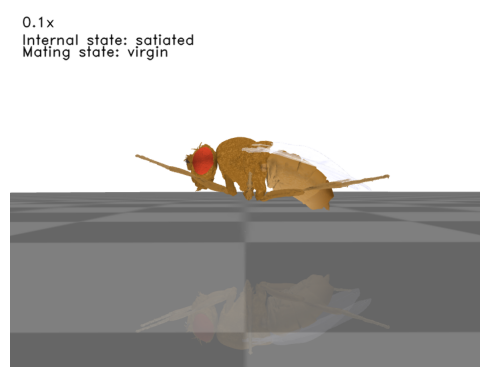

In [24]:
obs, _ = nmf.reset()
nmf.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(nmf._frames[-1])
ax.axis("off")

In [25]:
def generate_random_walk(num_steps):
    turnings = [np.array([1,1])]
    count_step_turn = 0
    total_step_turn = 100
    turn = False

    for i in range(num_steps - 1):

        if count_step_turn <= total_step_turn:
            sigma_l = turnings[-1][0]
            sigma_r = turnings[-1][1]

        elif turn:
            count_step_turn = 0
            total_step_turn = np.random.gamma(120, 50)
            turn = False
            sigma_l = 1.2
            sigma_r = 1.2
        
        else:
            count_step_turn = 0

            while True:
                sigma_l = np.random.choice([np.random.normal(1, 0.3),
                                                      np.random.normal(1.25, 0.2),
                                                      np.random.normal(0.15, 0.2)],
                                                      p=[0.5, 0.25, 0.25])
                if sigma_l >= 0.0 and sigma_l <= 1.5 : # change before >= 0.1
                    break

            if sigma_l > 1.2:
                proba_r = np.array([0.1, 0.1, 0.8])
            elif (sigma_l > 0.2 and sigma_l < 0.4):
                proba_r = np.array([0.1, 0.8, 0.1])
            elif sigma_l <= 0.2:
                proba_r = np.array([0.2, 0.8, 0.0])
            else:
                proba_r = np.array([0.6, 0.2, 0.2])

            while True:
                sigma_r = np.random.choice([np.random.normal(1, 0.3),
                                                      np.random.normal(1.25, 0.2),
                                                      np.random.normal(0.15, 0.2)],
                                                      p = proba_r)
                if sigma_r >= 0.05 and sigma_l <= 1.7 :
                    break

            if np.abs(sigma_l - sigma_r) > 0.65:
                total_step_turn = np.random.gamma(140, 65)
                turn = True
            else:
                total_step_turn = np.random.gamma(50, 30)
        
        count_step_turn += 1

        turnings.append(np.array([sigma_l,sigma_r]))
        
    return turnings

In [28]:
turns = generate_random_walk(int(run_time / nmf.sim_params.timestep))

magnitude_hist = []
fly_positions = []
obs, info = nmf.reset(seed=0)
for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i * nmf.sim_params.timestep
    action = turns[i]
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())
    fly_positions.append(obs["fly"][0,:])

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:32<00:00, 304.90it/s]


In [29]:
nmf.save_video("/home/nmf-learning/flygym-scratch/outputs/random_walk_withreward.mp4")